<h1>The Ising Model</h1>
In this assignment we calculate the magnetic susceptibility for particles in the Ising model using the metropolis monte-carlo system.

In [436]:
import numpy as np
import matplotlib.pyplot as plt

<h2>Generating Ising States</h2>


In [438]:
#N is the number of states on each axis. Returns an N*N array
def genState(N):
    return np.random.choice((-1, 1), (N, N))

def getMove(N):
    return np.random.randint(0, N*N)

def makeMove(spins, move):
    N = spins.shape[0]
    i, j = int( np.floor( move / N ) ), move%N

    if move == N*N:
        return -spins
    else:
        spins[i, j] *= -1
        return spins

<h2>Calculating Energies</h2>
We calculate the energy for a single state and also for a state given by a 'move' of either a single particle flip of all particles flipping.<br>
The energy is given by:

$$
E = - H \sum_i s_i - \sum_{\langle i,j \rangle} s_i s_j
$$

In [502]:
def hamiltonian( spins, H ) :
    N = spins.shape[0]
    energy = 0
    for i in range(N):
        for j in range(N):
          #Interactions - considers only right and down to avoid double counting
          if i < N-1:
            energy -= spins[i, j] * spins[i+1, j]
          if j < N-1:
            energy -= spins[i, j] * spins[i, j+1]
        
          #Magnetic field strength
          energy -= H * spins[i, j]
    
    return energy

#Move is an integer from 0 to N*N. N*N means flip all spins
def getNewEnergy(spins, H, prevE, move):
    N = spins.shape[0]
    i, j = int( np.floor( move / N ) ), move%N

    if move == N**2:
      return prevE + 2*H*np.sum(spins)
    
    neighbourSum = 0
    if i>0:
      neighbourSum += spins[i-1, j]
    if i<N-1:
      neighbourSum += spins[i+1, j]
    if j>0:
      neighbourSum += spins[i, j-1]
    if j<N-1:
      neighbourSum += spins[i, j+1]
    
    return prevE + 2*spins[i, j] * (neighbourSum + H)

<h2>Metropolis monte-carlo</h2>

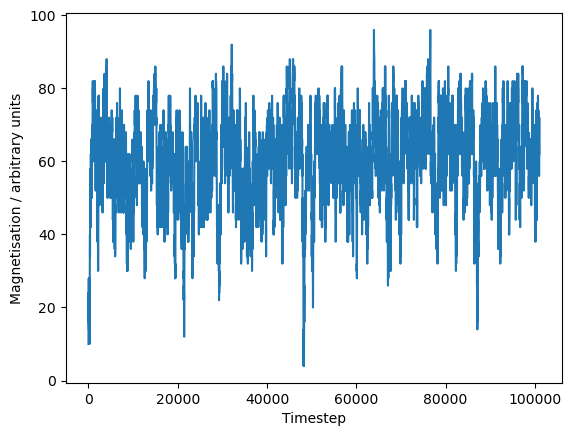

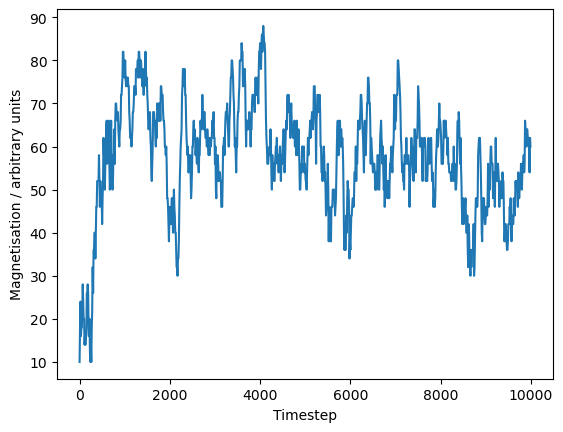

In [603]:
iterations = 100000 + 1000
stride = 10

N = 10
H = 1
temp = 4

spins = genState(N)
energy = hamiltonian(spins, H)

magnetisations = np.zeros(iterations//stride)
energies = np.zeros(iterations//stride)
times = np.zeros(iterations//stride)

for i in range(iterations):
    move = np.random.randint(0, N*N+1)
    newEnergy = getNewEnergy(spins, H, energy, move)

    if newEnergy <= energy:
        spins = makeMove(spins, move)
        energy = newEnergy
    else:
        acceptProb = np.exp(-(1/temp) * newEnergy) / np.exp(-(1/temp) * energy)
        if np.random.rand() < acceptProb:
            spins = makeMove(spins, move)
            energy = newEnergy

    #Records energy
    if i%stride == 0:
        magnetisations[i//stride] = np.sum(spins)
        energies[i//stride] = energy
        times[i//stride] = i


plt.plot(times, magnetisations)
plt.xlabel("Timestep")
plt.ylabel("Magnetisation / arbitrary units")

plt.figure()
plt.plot(times[0:10000//stride], magnetisations[0:10000//stride])
plt.xlabel("Timestep")
plt.ylabel("Magnetisation / arbitrary units")

#Removes first 1000 steps for equilibrium
magnetisations = magnetisations[1000//stride:]

<h2>Averaging Magnetisation</h2>
The magnetisation of any state can be calculated. We investigate how temperature and magnetic field strength affect this, quoting error bars.

We precompute and use an array of magnetisations before calculating block averages. 

As we see in the above figure, we should discard the first 1000 timesteps (100 values) to ensure the system has reached equilibrium.

Text(0, 0.5, 'Average Magnetisation / arbitrary units')

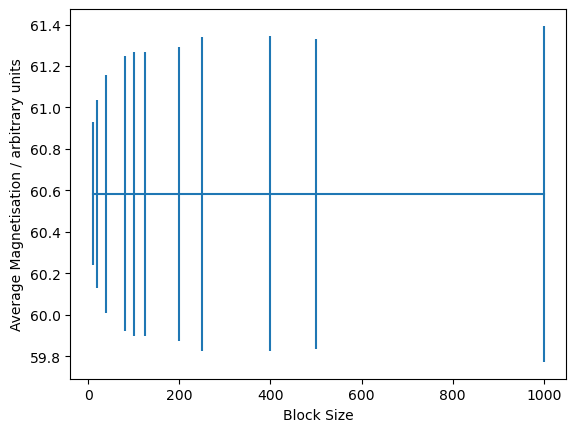

In [605]:
blockSizes = [10, 20, 40, 80, 100, 125, 200, 250, 400, 500, 1000]

magnetAvgs = np.zeros(len(blockSizes))
errors = np.zeros(len(blockSizes))

for b in range(len(blockSizes)):

    numBlocks = np.size(magnetisations) // blockSizes[b]

    
    #Averages the energies for each block
    blockAvg = 0
    blockAvgSquare = 0

    #Loop through all the blocks
    for i in range(numBlocks):#Number of blocks
        averageM = 0

        # Loop through data within each block
        for j in range(blockSizes[b]): 
            averageM += magnetisations[i * blockSizes[b] + j]
        averageM /= blockSizes[b]

        blockAvg += averageM
        blockAvgSquare += averageM ** 2
        
    blockAvg /= numBlocks
    blockAvgSquare /= numBlocks

    variance = 1/(numBlocks-1) * (blockAvgSquare - blockAvg ** 2)
    error = np.sqrt(variance)

    errors[b] = error
    magnetAvgs[b] = blockAvg

plt.errorbar(blockSizes, magnetAvgs, yerr=errors)
plt.xlabel("Block Size")
plt.ylabel("Average Magnetisation / arbitrary units")

In [586]:
len(magnetisations)

10000

<h2>Plotting the average</h2>

In [510]:
#Returns an average and an error for a given temp, magnetic field strength H and block size
def avgMag(N, temp, H, blockSize):
    iterations = 100000 + 1000 #1000 is the equilibriation phase
    stride = 10
    
    spins = genState(N)
    energy = hamiltonian(spins, H)
    
    magnetisations = np.zeros(iterations//stride)
    
    for i in range(iterations):
        move = np.random.randint(0, N*N+1)
        newEnergy = getNewEnergy(spins, H, energy, move)
    
        if newEnergy <= energy:
            spins = makeMove(spins, move)
            energy = newEnergy
        else:
            acceptProb = np.exp(-(1/temp) * newEnergy) / np.exp(-(1/temp) * energy)
            if np.random.rand() < acceptProb:
                spins = makeMove(spins, move)
                energy = newEnergy
    
        #Records magnetisation
        if i%stride == 0 and i >= 1000:
            magnetisations[i//stride] = np.sum(spins)
    
    numBlocks = np.size(magnetisations) // blockSizes[b]
    #Averages the energies for each block
    blockAvg = 0
    blockAvgSquare = 0
    for i in range(numBlocks):#Number of blocks
        averageM = 0
        for j in range(blockSizes[b]): # Data within each block
            averageM += magnetisations[i * blockSizes[b] + j]
        averageM /= blockSizes[b]
    
        blockAvg += averageM
        blockAvgSquare += averageM ** 2
    blockAvg /= numBlocks
    blockAvgSquare /= numBlocks
    
    variance = 1/(numBlocks-1) * (blockAvgSquare - blockAvg ** 2)
    error = np.sqrt(variance)

    return blockAvg, error
    

2, -4
2, -3.5
2, -3
2, -2.5
2, -2
2, -1.5
2, -1
2, -0.5
2, 0
2, 0.5
2, 1
2, 1.5
2, 2
2, 2.5
2, 3
2, 3.5
2, 4
4, -4
4, -3.5
4, -3
4, -2.5
4, -2
4, -1.5
4, -1
4, -0.5
4, 0
4, 0.5
4, 1
4, 1.5
4, 2
4, 2.5
4, 3
4, 3.5
4, 4
8, -4
8, -3.5
8, -3
8, -2.5
8, -2
8, -1.5
8, -1
8, -0.5
8, 0
8, 0.5
8, 1
8, 1.5
8, 2
8, 2.5
8, 3
8, 3.5
8, 4
20, -4
20, -3.5
20, -3
20, -2.5
20, -2
20, -1.5
20, -1
20, -0.5
20, 0
20, 0.5
20, 1
20, 1.5
20, 2
20, 2.5
20, 3
20, 3.5
20, 4


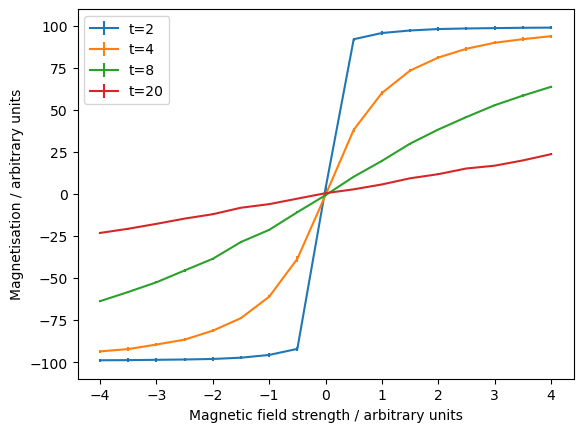

In [622]:
fieldStrength = [-4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
for temp in [2, 4, 8, 20]:
    magnetisation = np.zeros(len(fieldStrength))
    errors = np.zeros(len(fieldStrength))

    for i in range(len(fieldStrength)):
        magnetisation[i], errors[i] = avgMag(10, temp, fieldStrength[i], 200)

        print(f'{temp}, {fieldStrength[i]}')

    plt.errorbar(fieldStrength, magnetisation, yerr=errors, label=f't={temp}')

plt.xlabel("Magnetic field strength / arbitrary units")
plt.ylabel("Magnetisation / arbitrary units")
plt.legend()